# CS 584-A Final Project
# Toxic Comment Classification Technique: worst group accuracy optimization
# WGA Model

### Name: Brian Moon
### CWID: 10468944
### Stevens Institute of Technology
##### I pledge my honor that I have abided by the Stevens Honor System

In [1]:
!pip install -q transformers
!pip uninstall -y datasets
!pip install -q --upgrade huggingface_hub
!pip install -q datasets==2.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==

# 1: Import and Process Data



In [13]:
#Import packages
import pandas as pd
import datasets
import numpy as np
from datasets import Dataset
from transformers import(
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import torch
torch.cuda.is_available()


True

In [14]:
#Data directory (Change this depending on file location/machine)
from google.colab import drive
drive = drive.mount('/content/drive')
data_dir = 'drive/MyDrive/kaggle_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#Load data from given train and val data files
train_x = pd.read_csv(f"{data_dir}/train_x.csv", index_col=0)
train_y = pd.read_csv(f"{data_dir}/train_y.csv")
val_x = pd.read_csv(f"{data_dir}/val_x.csv", index_col=0)
val_y = pd.read_csv(f"{data_dir}/val_y.csv")

In [42]:
#Extract the input string and the binary label, and put it into a dataframe

identity_columns = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

train_df = pd.DataFrame({
    "text": train_x.iloc[:, 0].astype(str).tolist(),
    "labels": train_y["y"].astype(int).tolist(),
    **{col: train_y[col].astype(float).tolist() for col in identity_columns} #loop through each demographic, then access the columns in train_y that corresponds to that demographic
    #In the end, we will get things like "male":[0,1,0...], "female":[0,1,0...]
})

val_df = pd.DataFrame({
    "text": val_x.iloc[:, 0].astype(str).tolist(),
    "labels": val_y["y"].astype(int).tolist(),
    **{col: val_y[col].astype(float).tolist() for col in identity_columns} #repeated
})



#Convert those dataframes into a huggingface dataset to use for BERT
train_ds = Dataset.from_pandas(train_df).shuffle(seed=42).select(range(10_000))
val_ds = Dataset.from_pandas(val_df).shuffle(seed=42).select(range(2_000))

In [121]:
#Use BertTokenizer to tokenize our data to use for BERT model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
  tokenized = tokenizer(batch["text"], padding="max_length", truncation=True)
  tokenized["labels"] = batch["labels"]
  for col in identity_columns:
      tokenized[col] = batch[col]
  return tokenized

train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=[])
val_ds = val_ds.map(tokenize_fn, batched=True, remove_columns=[])


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [122]:
#Format for PyTorch
train_ds = train_ds.cast_column("labels", datasets.features.Value("float32"))
val_ds = val_ds.cast_column("labels", datasets.features.Value("float32"))


for col in identity_columns:
  train_ds = train_ds.cast_column(col, datasets.features.Value("float32"))
  val_ds = val_ds.cast_column(col,datasets.features.Value("float32"))


# train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
# val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Load Model

In [151]:
#Load model and set the training arguments
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

training_args = TrainingArguments(
    output_dir="./bert-toxic-wga",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_steps=20,
    remove_unused_columns=False,
    logging_strategy="steps"
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.nn.functional as F

class WGATrainer(Trainer): #custom trainer to use WGA in loss
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch = None):

        identity_columns = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
        identity_info = {col: inputs.pop(col) for col in identity_columns} #extract identity info
        labels = inputs.pop("labels")

        #forward pass through model
        outputs = model(**inputs)
        logits = outputs.logits.squeeze()

        #calculate probability
        probs = torch.sigmoid(logits)

        #calculate cross entropy loss based on the probabilities
        bce_loss = F.binary_cross_entropy(probs, labels)

        #use soft WGA approximation- how close are the probabilities to the true labels in each group?
        #this is different from strict WGA that uses binary classification as the metric, but it is less useful as a loss
        soft_group_accuracies = []
        for col in identity_columns:
            mask = identity_info[col] == 1
            if mask.sum() > 0:
                group_diff = torch.abs(probs[mask] - labels[mask])
                group_score = 1.0 - group_diff.mean()  # soft accuracy
                soft_group_accuracies.append(group_score)

        #fallback in case there is no identity group that exists in the whole batch
        if soft_group_accuracies:
            soft_wga = torch.stack(soft_group_accuracies).min()
        else:
            soft_wga = torch.tensor(0.0, device=logits.device)

        #log metrics
        self.log({"train/soft_wga": soft_wga.item()})
        self.log({"train/bce_loss": bce_loss.item()})
        if self.state.global_step%20==0:
          print("train/soft_wga:", soft_wga.item(),"| train/bce_loss:", bce_loss.item())

        #combine CE loss and soft WGA penalty
        fairness_weight = 1.0  # You can tune this hyperparameter
        loss = bce_loss + fairness_weight * (1.0 - soft_wga)

        return (loss, outputs) if return_outputs else loss


In [ ]:
def custom_data_collator(features): 
#the default collator does not support inputting additional columns
#so we need to implement a modification to the default data collator to match our code.
    identity_columns = ['male', 'female', 'LGBTQ', 'christian', 'muslim',
                        'other_religions', 'black', 'white']
    batch = {}

    #use torch's default collator first for core inputs
    input_keys = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
    for key in input_keys:
        batch[key] = torch.tensor([f[key] for f in features])

    #manually stack the identity columns if available
    for col in identity_columns:
        if col in features[0]:
            batch[col] = torch.tensor([f[col] for f in features], dtype=torch.float)

    return batch


In [162]:
#Set up trainer and train the model
from transformers import DataCollatorWithPadding

trainer = WGATrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator = custom_data_collator
)


<ipython-input-162-f825c90a784f>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WGATrainer.__init__`. Use `processing_class` instead.
  trainer = WGATrainer(


In [163]:
trainer.train()


train/soft_wga: 0.7844469547271729 | train/bce_loss: 0.12688633799552917


Step,Training Loss
20,0.468300
40,0.728400
60,0.797400
80,0.808800
100,0.828000
120,0.768900
140,0.714700
160,0.807800
180,0.654700
200,1.107900


train/soft_wga: 0.9754600524902344 | train/bce_loss: 0.024149473756551743
train/soft_wga: 0.34829187393188477 | train/bce_loss: 1.1091132164001465
train/soft_wga: 0.8689218163490295 | train/bce_loss: 0.10144243389368057
train/soft_wga: 0.6589802503585815 | train/bce_loss: 0.3274645507335663
train/soft_wga: 0.05324149131774902 | train/bce_loss: 0.2403821051120758
train/soft_wga: 0.19394993782043457 | train/bce_loss: 0.30857300758361816
train/soft_wga: 0.6902883648872375 | train/bce_loss: 0.17861394584178925
train/soft_wga: 0.7137901782989502 | train/bce_loss: 0.22592923045158386
train/soft_wga: 0.8018778562545776 | train/bce_loss: 0.8998183012008667
train/soft_wga: 0.05037367343902588 | train/bce_loss: 0.35856324434280396
train/soft_wga: 0.06740927696228027 | train/bce_loss: 0.23396950960159302
train/soft_wga: 0.8442500829696655 | train/bce_loss: 0.1504192352294922
train/soft_wga: 0.7535439133644104 | train/bce_loss: 0.19437436759471893
train/soft_wga: 0.6581506729125977 | train/bce_los

TrainOutput(global_step=1875, training_loss=0.5255647062937419, metrics={'train_runtime': 2732.4613, 'train_samples_per_second': 10.979, 'train_steps_per_second': 0.686, 'total_flos': 7893260789760000.0, 'train_loss': 0.5255647062937419, 'epoch': 3.0})

In [166]:
#Get predictions for fairness analysis
pred_output = trainer.predict(val_ds)
logits = pred_output.predictions
labels = pred_output.label_ids


In [167]:
from sklearn.metrics import f1_score, accuracy_score
probs = torch.sigmoid(torch.tensor(logits)).numpy()
print(max(probs))
preds = (probs > .5).astype(int).flatten()

acc = accuracy_score(labels,preds)
f1 = f1_score(labels,preds,average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"F1 Macro: {f1:.4f}")

[0.9966446]
Accuracy: 0.9185
F1 Macro: 0.7647


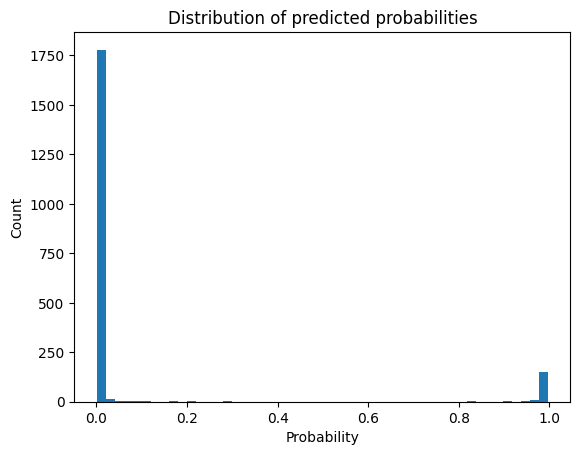

In [168]:
import matplotlib.pyplot as plt

plt.hist(probs, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()


The distribution this time suggests a frighteningly divided split where the probabilities are almost all 0 or 1. This suggest potential overfitting, but the accuracy was much higher at 0.91. \\
Although the accuracy drastically improved, it is still likely overfit.

If we evaluate the predictions that are made, we can threshold at 0.5 probability. We want to evaluate \\
1: how many toxic comments get through this detector? \\
2: how many flagged comments are false positives?

### Undetected toxic comment evaluation:

In [176]:
confidence_mask = probs.flatten() <.5
filtered_preds = (probs[confidence_mask] > 0.5)
filtered_labels = labels[confidence_mask]

filtered_acc = accuracy_score(filtered_labels, filtered_preds)
filtered_f1 = f1_score(filtered_labels, filtered_preds, average="macro")
print(f"Accuracy (prob < 0.5): {filtered_acc:.4f}")
print(f"F1 score (prob < 0.5): {filtered_f1:.4f}")


Accuracy (prob < 0.5): 0.9463
F1 score (prob < 0.5): 0.4862


### False positive evaluation:

In [175]:
confidence_mask = probs.flatten() >.5
filtered_preds = (probs[confidence_mask] > 0.5)
filtered_labels = labels[confidence_mask]

filtered_acc = accuracy_score(filtered_labels, filtered_preds)
filtered_f1 = f1_score(filtered_labels, filtered_preds, average="macro")
print(f"Accuracy (prob > 0.5): {filtered_acc:.4f}")
print(f"F1 score (prob > 0.5): {filtered_f1:.4f}")


Accuracy (prob > 0.5): 0.6286
F1 score (prob > 0.5): 0.3860


### Sample outputs (selected to have a variety out outcomes)

In [222]:
import pandas as pd
val_ds_output = Dataset.from_pandas(val_df).shuffle(seed=42).select(range(2_000))
identity_info = {col: val_ds[col] for col in identity_columns}

# Choose indices you want to examine
indices = [47,61,67,78,99]
for i in indices:
    print(f"\nSample {i}")
    print("Text:", val_ds_output["text"][i])
    print("Prob:", probs[i])
    print("True Label:", labels[i])
    print("Binary Prediction:", int(probs[i] > 0.5))
    print("Identities:", {col: identity_info[col][i] for col in identity_columns if identity_info[col][i] == 1})



Sample 47
Text: So you're the white guy that can call black guys the n word because you have a black friend.
Prob: [0.9960646]
True Label: 0.0
Binary Prediction: 1
Identities: {'male': 1.0, 'black': 1.0, 'white': 1.0}

Sample 61
Text: white media??????? what are you on about? any criticism is in your eyes, racist. that excuse died 100 years ago.
Prob: [0.00924019]
True Label: 1.0
Binary Prediction: 0
Identities: {'white': 1.0}

Sample 67
Text: The Trump voters remind me of the "good Germans" too. They would be happy if the rest of us that didn't vote for Trump would just disappear. They would never ask where we disappeared to. The GOP is just a white identity party in the 21st century. They have been endorsed by white supremacists from coast to coast and border to border. They all may not be white racists, however they are all sympathizers with white supremacists.
Prob: [0.02671864]
True Label: 0.0
Binary Prediction: 0
Identities: {'white': 1.0}

Sample 78
Text: No, Arpaio was found g

<ipython-input-222-5ab4c5e0847c>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Binary Prediction:", int(probs[i] > 0.5))
